# Report Práctica Predicción Abandono

___________________________________________________________________

En las siguientes celdas adjunto el código que he usado para entrenar el módelo (Gradient Boosting) con el que he obtenido los mejores resultados en balanced accuracy. No obstante, ha habido muchas más fases en este proyecto en las que el código no resultaba así. 

Debajo de las conclusiones y resultados podrá encontrar las diferentes pruebas tanto de modelos como parámetros o limpieza/preprocesado que se han hecho

___________________________________________________________________

### Imports

In [24]:
import numpy as np
import random
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# Preprocesado
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Prueba de Modelos
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
# Evaluacion
from sklearn.metrics import (balanced_accuracy_score, classification_report,
                              confusion_matrix, roc_auc_score, accuracy_score,
                              precision_score, recall_score, f1_score)
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Fijamos Semilla
random.seed(100473223)
np.random.seed(100473223)


### Clase de Feature Engineering

In [25]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Crea features derivadas para capturar patrones no lineales"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Evitar división por cero
        def safe_divide(a, b):
            return np.where(b != 0, a / b, 0)
        
        # Estabilidad laboral
        X['Years_per_Company_Ratio'] = safe_divide(
            X['Total Active Years'], 
            X['Number of Other Companies'] + 1
        )
        
        # Retraso en promoción
        X['Promotion_Lag'] = X['Years at Current Company'] - X['Years Since Last Promotion']
        
        # Ingreso por año de experiencia
        X['Income_per_Year'] = safe_divide(
            X['Yearly Income'], 
            X['Total Active Years'] + 1
        )
        
        # Estabilidad con manager actual
        X['Manager_Stability'] = safe_divide(
            X['Years with Current Manager'], 
            X['Years at Current Company'] + 1
        )
        
        # Satisfacción general (promedio de satisfacciones)
        satisfaction_cols = ['Job Satisfaction', 'Environment Satisfaction', 
                            'Work Life Balance Satisfaction']
        
        # Manejar valores faltantes temporalmente para el cálculo
        X['Overall_Satisfaction'] = X[satisfaction_cols].mean(axis=1, skipna=True)
        
        # Baja satisfacción general
        X['Low_Satisfaction'] = (X['Overall_Satisfaction'] < 3).astype(int)
        
        # Empleado recién contratado
        X['Recent_Hire'] = (X['Years at Current Company'] < 2).astype(int)
        
        # Promoción atrasada
        X['Overdue_Promotion'] = (X['Years Since Last Promotion'] > 3).astype(int)
        
        # Commute largo (si la columna existe)
        if 'Miles from Home to Work' in X.columns:
            X['Long_Commute'] = (X['Miles from Home to Work'] > 20).astype(int)
        
        # Edad vs. Nivel de trabajo (senior joven o junior viejo = señal)
        X['Age_x_JobLevel'] = X['Age'] * pd.factorize(X.get('Job Level', pd.Series([0]*len(X))))[0]
        
        # Satisfacción baja + salario bajo = alto riesgo
        X['LowSat_LowIncome'] = (
            (X['Overall_Satisfaction'] < 3) & 
            (X['Yearly Income'] < X['Yearly Income'].median())
        ).astype(int)
        
        return X

### 1. Carga y Exploración de Datos

In [26]:
data = pd.read_csv('../train.csv')

print(f"\nDimensiones del dataset: {data.shape}")
print(f"\nDistribución de la clase objetivo (Attrition):")
print(data['Attrition'].value_counts())
attrition_dist = data['Attrition'].value_counts(normalize=True) * 100
print(f"\nPorcentaje de Attrition:\n{attrition_dist}")

# Ratio de desbalanceo (solo informativo)
class_counts = data['Attrition'].value_counts()
imbalance_ratio = class_counts['No'] / class_counts['Yes']
print(f"\n⚠ Ratio de desbalanceo: {imbalance_ratio:.2f}:1")
print(f"Clase minoritaria (Yes): {attrition_dist['Yes']:.1f}%")
print("→ Se usará SMOTE en el pipeline de entrenamiento y CV.")




Dimensiones del dataset: (3528, 27)

Distribución de la clase objetivo (Attrition):
Attrition
No     2956
Yes     572
Name: count, dtype: int64

Porcentaje de Attrition:
Attrition
No     83.786848
Yes    16.213152
Name: proportion, dtype: float64

⚠ Ratio de desbalanceo: 5.17:1
Clase minoritaria (Yes): 16.2%
→ Se usará SMOTE en el pipeline de entrenamiento y CV.


### 2. División en Entrenamiento y Test

In [27]:
X = data.drop(['Attrition', 'ID'], axis=1)
y = data['Attrition'].map({'No': 0, 'Yes': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y
)

print(f"\nConjunto de entrenamiento: {X_train.shape[0]} instancias")
print(f"Conjunto de test: {X_test.shape[0]} instancias")
print(f"\nDistribución en entrenamiento:\n{y_train.value_counts()}")
print(f"\nDistribución en test:\n{y_test.value_counts()}")




Conjunto de entrenamiento: 2822 instancias
Conjunto de test: 706 instancias

Distribución en entrenamiento:
Attrition
0    2364
1     458
Name: count, dtype: int64

Distribución en test:
Attrition
0    592
1    114
Name: count, dtype: int64


### 3. Preprocesado de datos

In [28]:
numerical_cols = [
    'Age', 'Miles from Home to Work', 'Yearly Income', 'Absences per Year',
    'Performance Rating', 'Job Satisfaction', 'Environment Satisfaction',
    'Work Life Balance Satisfaction', 'Last Salary Increase (%)',
    'Number of Training Sessions Last Year', 'Number of Other Companies',
    'Total Active Years', 'Years at Current Company',
    'Years Since Last Promotion', 'Years with Current Manager'
]

ordinal_cols = {
    'Education Level': [['High School', 'College', 'Bachelor', 'Master', 'Doctor']],
    'Job Level': [['Entry Level', 'Mid Level', 'Senior Level', 'Director', 'Executive']],
    'Job Involvement': [['Low', 'Medium', 'High', 'Very High']]
}

categorical_cols = [
    'Gender', 'Marital Status', 'Education Field', 'Department Name',
    'Job Role Name', 'Business Travel Frequency', 'Amount of Stock Option'
]

print(f"\nColumnas numéricas: {len(numerical_cols)}")
print(f"Columnas ordinales: {len(ordinal_cols)}")
print(f"Columnas categóricas: {len(categorical_cols)}")


# Análisis de valores faltantes
print("\n" + "="*50)
print("ANÁLISIS DE VALORES FALTANTES")
print("="*50)
missing_values = X_train.isnull().sum()
missing_percent = (missing_values / len(X_train)) * 100
missing_df = pd.DataFrame({
    'Columna': missing_values.index,
    'Valores_Faltantes': missing_values.values,
    'Porcentaje': missing_percent.values
})
missing_df = missing_df[missing_df['Valores_Faltantes'] > 0].sort_values('Valores_Faltantes', ascending=False)
if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("✓ No hay valores faltantes en el dataset")
print(f"\nTotal de columnas con valores faltantes: {len(missing_df)}")
    
# Eliminar columnas con >30% de valores faltantes
cols_to_drop = missing_df[missing_df['Porcentaje'] > 30]['Columna'].tolist()
if cols_to_drop:
    print(f"\n⚠ Eliminando columnas con >30% de valores faltantes: {cols_to_drop}")
    X_train = X_train.drop(columns=cols_to_drop)
    X_test = X_test.drop(columns=cols_to_drop)
    
    # Actualizar listas de columnas
    numerical_cols = [col for col in numerical_cols if col not in cols_to_drop]
    categorical_cols = [col for col in categorical_cols if col not in cols_to_drop]
    ordinal_cols = {k: v for k, v in ordinal_cols.items() if k not in cols_to_drop}
    
    print(f"✓ Columnas eliminadas. Nuevas dimensiones: {X_train.shape}")
else:
    print("✓ No hay valores faltantes en el dataset")
# === PREPROCESADO ===

# 1) Transformadores por tipo de columna
num_transformer = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Un pipeline ordinal por cada columna ordinal (imputar + codificar)
ord_transformers = []
for col, categories in ordinal_cols.items():
    ord_transformers.append((
        f'ord_{col}',
        ImbPipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(
                categories=categories,
                handle_unknown='use_encoded_value',
                unknown_value=-1
            ))        
        ]),
        [col]
    ))

cat_transformer = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# 2) Un único ColumnTransformer como preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        *ord_transformers,
        ('cat', cat_transformer, categorical_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

# 3) Pipeline FINAL con SMOTE (Sin nested Pipeline en pasos intermedios)
# MEJORA #2: Usar SMOTE
ml_pipe_improved = ImbPipeline(steps=[
    ('feature_engineer', FeatureEngineer()),  # "Juego de features"
    ('preprocessor', preprocessor),
    #('smote', BorderlineSMOTE(random_state=42, kind='borderline-1')),  # Tiene en cuenta los bordes
    ('smote', SMOTE(random_state=42)),  # Tiene en cuenta los bordes --- IGNORE ---
    ('classifier', LogisticRegression())  # placeholder
])





Columnas numéricas: 15
Columnas ordinales: 3
Columnas categóricas: 7

ANÁLISIS DE VALORES FALTANTES
                       Columna  Valores_Faltantes  Porcentaje
        Amount of Stock Option               1213   42.983700
       Miles from Home to Work                572   20.269313
                Marital Status                419   14.847626
Work Life Balance Satisfaction                168    5.953225
              Job Satisfaction                154    5.457123
      Environment Satisfaction                139    4.925585
     Number of Other Companies                 11    0.389794
            Total Active Years                  4    0.141743

Total de columnas con valores faltantes: 8

⚠ Eliminando columnas con >30% de valores faltantes: ['Amount of Stock Option']
✓ Columnas eliminadas. Nuevas dimensiones: (2822, 24)


### Modelos a probar: 
(Las pruebas descartadas están incluidas debajo de los resultados oficiales)

In [29]:
grid= [
    # Gradient Boosting - Excelente para balanced accuracy
    {
        'classifier': [GradientBoostingClassifier(random_state=42)],
        'classifier__n_estimators': [600],
        'classifier__learning_rate': [0.15],
        'classifier__max_depth': [5],
        'classifier__subsample': [0.9],
        'classifier__min_samples_leaf': [7]
    }
]
# La mejor combinación será (en mi experiencia): {'classifier': GradientBoostingClassifier(random_state=42), 'classifier__learning_rate': 0.15, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 7, 'classifier__n_estimators': 600, 'classifier__subsample': 0.9}


### Inicializamos la búsqueda

In [30]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search_smote = GridSearchCV(
    estimator=ml_pipe_improved,   # ImbPipeline
    param_grid=grid,
    scoring='balanced_accuracy',
    cv=cv,
    n_jobs=-1,
    error_score='raise',
    verbose = 1,
)


print("\nIniciando búsqueda CON SMOTE integrado (CV estratificada)...")
search_smote.fit(X_train, y_train)
print("✓ Búsqueda CON SMOTE completada!")

print(f"\nMejor modelo CON SMOTE:")
print(f"  Clasificador: {search_smote.best_estimator_['classifier'].__class__.__name__}")
print(f"  Balanced Accuracy (CV): {search_smote.best_score_:.4f}")

best_model = search_smote.best_estimator_

def find_optimal_threshold(model, X_val, y_val):
    """Encuentra el threshold óptimo para balanced accuracy"""
    y_proba = model.predict_proba(X_val)[:, 1]
    
    thresholds = np.arange(0.1, 0.9, 0.01)
    scores = []
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        score = balanced_accuracy_score(y_val, y_pred)
        scores.append(score)
    
    optimal_idx = np.argmax(scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_score = scores[optimal_idx]
    
    print(f"Threshold por defecto (0.5): {balanced_accuracy_score(y_val, (y_proba >= 0.5).astype(int)):.4f}")
    print(f"Threshold óptimo encontrado: {optimal_threshold:.3f}")
    print(f"Balanced Accuracy con threshold óptimo: {optimal_score:.4f}")
    print(f"Mejora: +{(optimal_score - balanced_accuracy_score(y_val, (y_proba >= 0.5).astype(int))):.4f}")
    
    return optimal_threshold

# Encontrar threshold óptimo en train
#optimal_threshold = find_optimal_threshold(best_model, X_train, y_train)
optimal_threshold = 0.5  # Mantener 0.5 por ahora  


Iniciando búsqueda CON SMOTE integrado (CV estratificada)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
✓ Búsqueda CON SMOTE completada!

Mejor modelo CON SMOTE:
  Clasificador: GradientBoostingClassifier
  Balanced Accuracy (CV): 0.9067


### Mejor Modelo:
{'classifier': GradientBoostingClassifier(random_state=42), 'classifier__learning_rate': 0.15, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 7, 'classifier__n_estimators': 600, 'classifier__subsample': 0.9}

### 5. Evaluación en test

In [31]:
# Predicciones con threshold por defecto (0.5)
y_pred_default = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Predicciones con threshold óptimo
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

# Métricas con threshold por defecto
ba_default = balanced_accuracy_score(y_test, y_pred_default)
acc_default = accuracy_score(y_test, y_pred_default)
prec_default = precision_score(y_test, y_pred_default)
rec_default = recall_score(y_test, y_pred_default)
f1_default = f1_score(y_test, y_pred_default)

# Métricas con threshold óptimo
ba_optimal = balanced_accuracy_score(y_test, y_pred_optimal)
acc_optimal = accuracy_score(y_test, y_pred_optimal)
prec_optimal = precision_score(y_test, y_pred_optimal)
rec_optimal = recall_score(y_test, y_pred_optimal)
f1_optimal = f1_score(y_test, y_pred_optimal)
auc = roc_auc_score(y_test, y_proba)

# Comparación de métricas
metrics_comparison = pd.DataFrame({
    'Métrica': ['Balanced Accuracy', 'Accuracy', 'Precision (Yes)', 'Recall (Yes)', 'F1-Score (Yes)', 'AUC-ROC'],
    'Threshold 0.5': [ba_default, acc_default, prec_default, rec_default, f1_default, auc],
    'Threshold Óptimo': [ba_optimal, acc_optimal, prec_optimal, rec_optimal, f1_optimal, auc],
    'Mejora': [
        ba_optimal - ba_default,
        acc_optimal - acc_default,
        prec_optimal - prec_default,
        rec_optimal - rec_default,
        f1_optimal - f1_default,
        0
    ]
})

print("\n📊 COMPARACIÓN DE RESULTADOS:")
print(metrics_comparison.to_string(index=False))

print(f"\n🎉 Balanced Accuracy Final: {ba_optimal:.4f}")
print(f"   Mejora vs threshold 0.5: +{(ba_optimal - ba_default):.4f}")

# Matriz de confusión con threshold óptimo
cm = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm.ravel()
print("\n📋 Matriz de Confusión (Threshold Óptimo):")
print(cm)
print(f"  TP={tp}, FP={fp}, FN={fn}, TN={tn}")

print("\n📄 REPORTE DE CLASIFICACIÓN (Threshold Óptimo):")
print(classification_report(y_test, y_pred_optimal, target_names=['No Attrition', 'Attrition']))



📊 COMPARACIÓN DE RESULTADOS:
          Métrica  Threshold 0.5  Threshold Óptimo  Mejora
Balanced Accuracy       0.959845          0.959845     0.0
         Accuracy       0.980170          0.980170     0.0
  Precision (Yes)       0.946429          0.946429     0.0
     Recall (Yes)       0.929825          0.929825     0.0
   F1-Score (Yes)       0.938053          0.938053     0.0
          AUC-ROC       0.976485          0.976485     0.0

🎉 Balanced Accuracy Final: 0.9598
   Mejora vs threshold 0.5: +0.0000

📋 Matriz de Confusión (Threshold Óptimo):
[[586   6]
 [  8 106]]
  TP=106, FP=6, FN=8, TN=586

📄 REPORTE DE CLASIFICACIÓN (Threshold Óptimo):
              precision    recall  f1-score   support

No Attrition       0.99      0.99      0.99       592
   Attrition       0.95      0.93      0.94       114

    accuracy                           0.98       706
   macro avg       0.97      0.96      0.96       706
weighted avg       0.98      0.98      0.98       706



#### Mal cálculo de threshold:
Al calcular el threshold óptimo me sale 0.1, lo cual es bueno y mejorará mi rendimiento en test en este caso pero no lo veo aplicable a más datasets; por esto, he decidido dejar 0.5, dejo la función creada para dejar por escrito el intento!

### 6. Guardar Modelo y Resultados

In [32]:
model_data = {
    'model': best_model,
    'optimal_threshold': optimal_threshold,
    'feature_names': X_train.columns.tolist()
}
with open('best_model_improved.pkl', 'wb') as f:
    pkl.dump(model_data, f)

## Plots Interesantes

In [33]:
# ===================================================================
# VISUALIZACIONES PARA REPORT - ANÁLISIS EXPLORATORIO Y RESULTADOS
# ===================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# ===================================================================
# 1. ANÁLISIS DE CORRELACIONES
# ===================================================================

def plot_correlation_analysis(data, target_col='Attrition'):
    """Análisis completo de correlaciones"""
    
    # Convertir target a numérico si es necesario
    data_num = data.copy()
    if data_num[target_col].dtype == 'object':
        data_num[target_col] = data_num[target_col].map({'No': 0, 'Yes': 1})
    
    # Solo columnas numéricas para correlación
    numeric_cols = data_num.select_dtypes(include=[np.number]).columns
    corr_data = data_num[numeric_cols]
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1.1 Heatmap de correlaciones completo
    corr_matrix = corr_data.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8}, ax=axes[0,0])
    axes[0,0].set_title('Matriz de Correlación - Variables Numéricas')
    
    # 1.2 Correlaciones con Attrition (top features)
    target_corr = corr_matrix[target_col].abs().sort_values(ascending=False)[1:16]  # Top 15
    
    sns.barplot(x=target_corr.values, y=target_corr.index, ax=axes[0,1])
    axes[0,1].set_title('Top 15 Correlaciones con Attrition (Valor Absoluto)')
    axes[0,1].set_xlabel('Correlación Absoluta')
    
    # 1.3 Scatter plot de las variables más correlacionadas
    top_features = target_corr.head(6).index.tolist()
    
    if len(top_features) >= 2:
        sns.scatterplot(data=data_num, x=top_features[0], y=top_features[1], 
                       hue=target_col, alpha=0.6, ax=axes[1,0])
        axes[1,0].set_title(f'Relación: {top_features[0]} vs {top_features[1]}')
    
    # 1.4 Distribución de correlaciones
    all_corrs = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
    axes[1,1].hist(all_corrs, bins=30, alpha=0.7, edgecolor='black')
    axes[1,1].axvline(0, color='red', linestyle='--', alpha=0.8)
    axes[1,1].set_title('Distribución de Todas las Correlaciones')
    axes[1,1].set_xlabel('Correlación')
    axes[1,1].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    #plt.savefig('correlation_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return target_corr

# ===================================================================
# 2. ANÁLISIS DE DISTRIBUCIONES POR ATTRITION
# ===================================================================

def plot_feature_distributions(data, target_col='Attrition', top_n=8):
    """Distribuciones de variables clave por clase objetivo"""
    
    # Variables numéricas más importantes
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    
    # Si hay más de top_n columnas, seleccionar las más relevantes
    if len(numeric_cols) > top_n:
        data_num = data.copy()
        if data_num[target_col].dtype == 'object':
            data_num[target_col] = data_num[target_col].map({'No': 0, 'Yes': 1})
        
        corr_with_target = data_num[numeric_cols].corrwith(data_num[target_col]).abs()
        top_features = corr_with_target.sort_values(ascending=False).head(top_n).index
    else:
        top_features = numeric_cols
    
    n_features = len(top_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, feature in enumerate(top_features):
        if i < len(axes):
            # Histogram con overlay por clase
            for attrition_val in data[target_col].unique():
                subset = data[data[target_col] == attrition_val][feature].dropna()
                axes[i].hist(subset, alpha=0.6, label=f'Attrition={attrition_val}', 
                           bins=20, density=True)
            
            axes[i].set_title(f'Distribución: {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Densidad')
            axes[i].legend()
    
    # Ocultar axes extra
    for i in range(len(top_features), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    #plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()

# ===================================================================
# 3. ANÁLISIS CATEGÓRICO
# ===================================================================

def plot_categorical_analysis(data, target_col='Attrition'):
    """Análisis de variables categóricas"""
    
    categorical_cols = data.select_dtypes(include=['object']).columns
    categorical_cols = [col for col in categorical_cols if col != target_col and col != 'ID']
    
    if len(categorical_cols) == 0:
        print("No hay variables categóricas para analizar")
        return
    
    n_cats = min(6, len(categorical_cols))  # Máximo 6 para visualización
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, col in enumerate(categorical_cols[:n_cats]):
        # Crear tabla de contingencia
        ct = pd.crosstab(data[col], data[target_col], normalize='index') * 100
        
        ct.plot(kind='bar', ax=axes[i], rot=45)
        axes[i].set_title(f'Attrition Rate por {col}')
        axes[i].set_ylabel('Porcentaje (%)')
        axes[i].legend(title='Attrition')
    
    # Ocultar axes extra
    for i in range(n_cats, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    #plt.savefig('categorical_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

# ===================================================================
# 4. FEATURE IMPORTANCE (si tienes el modelo entrenado)
# ===================================================================

def plot_feature_importance(model, X_train, y_train, feature_names=None, top_n=15):
    """Importancia de features del modelo"""
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # 4.1 Feature Importance del modelo (si está disponible)
    if hasattr(model, 'feature_importances_'):
        if feature_names is None:
            feature_names = [f'Feature_{i}' for i in range(len(model.feature_importances_))]
        
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False).head(top_n)
        
        sns.barplot(data=importance_df, x='importance', y='feature', ax=axes[0])
        axes[0].set_title('Feature Importance (Model-based)')
        axes[0].set_xlabel('Importancia')
    else:
        axes[0].text(0.5, 0.5, 'Feature Importance\nno disponible\npara este modelo', 
                    ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title('Feature Importance (Model-based)')
    
    # 4.2 Permutation Importance
    try:
        # Usar una muestra para acelerar el cálculo
        if len(X_train) > 1000:
            sample_idx = np.random.choice(len(X_train), 1000, replace=False)
            X_sample = X_train.iloc[sample_idx]
            y_sample = y_train.iloc[sample_idx]
        else:
            X_sample = X_train
            y_sample = y_train
            
        perm_importance = permutation_importance(model, X_sample, y_sample, 
                                               n_repeats=5, random_state=42,
                                               scoring='balanced_accuracy')
        
        if feature_names is None and hasattr(X_train, 'columns'):
            feature_names = X_train.columns.tolist()
        elif feature_names is None:
            feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]
            
        perm_df = pd.DataFrame({
            'feature': feature_names,
            'importance': perm_importance.importances_mean,
            'std': perm_importance.importances_std
        }).sort_values('importance', ascending=False).head(top_n)
        
        axes[1].barh(range(len(perm_df)), perm_df['importance'], 
                    xerr=perm_df['std'], alpha=0.7)
        axes[1].set_yticks(range(len(perm_df)))
        axes[1].set_yticklabels(perm_df['feature'])
        axes[1].set_title('Permutation Importance')
        axes[1].set_xlabel('Disminución en Balanced Accuracy')
        axes[1].invert_yaxis()
        
    except Exception as e:
        axes[1].text(0.5, 0.5, f'Error calculando\nPermutation Importance:\n{str(e)}', 
                    ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Permutation Importance (Error)')
    
    plt.tight_layout()
    #plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

# ===================================================================
# 5. CURVAS ROC Y MÉTRICAS DEL MODELO
# ===================================================================

def plot_model_performance(y_test, y_pred, y_proba, optimal_threshold=0.5):
    """Visualización completa del rendimiento del modelo"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 5.1 Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    axes[0,0].plot(fpr, tpr, color='darkorange', lw=2, 
                   label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0,0].set_xlim([0.0, 1.0])
    axes[0,0].set_ylim([0.0, 1.05])
    axes[0,0].set_xlabel('False Positive Rate')
    axes[0,0].set_ylabel('True Positive Rate')
    axes[0,0].set_title('Receiver Operating Characteristic (ROC)')
    axes[0,0].legend(loc="lower right")
    axes[0,0].grid(True, alpha=0.3)
    
    # 5.2 Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
    axes[0,1].set_title('Matriz de Confusión')
    axes[0,1].set_xlabel('Predicción')
    axes[0,1].set_ylabel('Real')
    
    # 5.3 Distribución de Probabilidades
    prob_df = pd.DataFrame({
        'probabilidad': y_proba,
        'real': y_test
    })
    
    for class_val in [0, 1]:
        class_probs = prob_df[prob_df['real'] == class_val]['probabilidad']
        axes[1,0].hist(class_probs, alpha=0.6, bins=30, 
                      label=f'Clase {class_val}', density=True)
    
    axes[1,0].axvline(optimal_threshold, color='red', linestyle='--', 
                     label=f'Threshold óptimo: {optimal_threshold:.3f}')
    axes[1,0].set_xlabel('Probabilidad predicha')
    axes[1,0].set_ylabel('Densidad')
    axes[1,0].set_title('Distribución de Probabilidades por Clase')
    axes[1,0].legend()
    
    # 5.4 Threshold vs Métricas
    from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
    
    thresholds_range = np.arange(0.1, 0.9, 0.01)
    metrics = {'precision': [], 'recall': [], 'f1': [], 'balanced_acc': []}
    
    for thresh in thresholds_range:
        y_pred_thresh = (y_proba >= thresh).astype(int)
        
        if len(np.unique(y_pred_thresh)) > 1:  # Evitar divisiones por cero
            metrics['precision'].append(precision_score(y_test, y_pred_thresh))
            metrics['recall'].append(recall_score(y_test, y_pred_thresh))
            metrics['f1'].append(f1_score(y_test, y_pred_thresh))
            metrics['balanced_acc'].append(balanced_accuracy_score(y_test, y_pred_thresh))
        else:
            # Si solo predice una clase, métricas serán 0 o 1
            metrics['precision'].append(0)
            metrics['recall'].append(0 if np.all(y_pred_thresh == 0) else 1)
            metrics['f1'].append(0)
            metrics['balanced_acc'].append(0.5)
    
    for metric_name, values in metrics.items():
        axes[1,1].plot(thresholds_range, values, label=metric_name.replace('_', ' ').title())
    
    axes[1,1].axvline(optimal_threshold, color='red', linestyle='--', alpha=0.7)
    axes[1,1].set_xlabel('Threshold')
    axes[1,1].set_ylabel('Métrica')
    axes[1,1].set_title('Métricas vs Threshold')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    #plt.savefig('model_performance.png', dpi=150, bbox_inches='tight')
    plt.show()

# ===================================================================
# 6. COMPARACIÓN DE MODELOS (si tienes varios)
# ===================================================================

def plot_model_comparison(results_dict):
    """
    Comparación visual de múltiples modelos
    
    Args:
        results_dict: Dict con formato:
        {
            'Modelo1': {'balanced_accuracy': 0.85, 'precision': 0.80, 'recall': 0.90, 'f1': 0.85},
            'Modelo2': {'balanced_accuracy': 0.82, 'precision': 0.85, 'recall': 0.78, 'f1': 0.81}
        }
    """
    if not results_dict:
        print("No hay resultados de modelos para comparar")
        return
    
    df_results = pd.DataFrame(results_dict).T
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 6.1 Barplot de métricas
    df_results.plot(kind='bar', ax=axes[0], rot=45)
    axes[0].set_title('Comparación de Métricas por Modelo')
    axes[0].set_ylabel('Score')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    # 6.2 Radar chart (si hay suficientes métricas)
    if len(df_results.columns) >= 3:
        angles = np.linspace(0, 2*np.pi, len(df_results.columns), endpoint=False)
        angles = np.concatenate((angles, [angles[0]]))  # Cerrar el círculo
        
        ax_radar = plt.subplot(122, projection='polar')
        
        for idx, (model_name, row) in enumerate(df_results.iterrows()):
            values = row.values.tolist()
            values += values[:1]  # Cerrar el círculo
            
            ax_radar.plot(angles, values, 'o-', linewidth=2, label=model_name)
            ax_radar.fill(angles, values, alpha=0.25)
        
        ax_radar.set_xticks(angles[:-1])
        ax_radar.set_xticklabels(df_results.columns)
        ax_radar.set_ylim(0, 1)
        ax_radar.set_title('Comparación Radar - Modelos')
        ax_radar.legend(bbox_to_anchor=(1.3, 1.0))
    else:
        axes[1].text(0.5, 0.5, 'Radar Chart\nrequiere al menos\n3 métricas', 
                    ha='center', va='center', transform=axes[1].transAxes)
    
    plt.tight_layout()
    #plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

In [34]:
data=data
model=best_model
X_train=X_train
y_train=y_train
X_test=X_test
y_test=y_test
y_pred=y_pred_optimal
y_proba=y_proba
optimal_threshold=optimal_threshold
results_dict={
        'GradientBoosting': {
            'balanced_accuracy': ba_optimal,
            'precision': prec_optimal,
            'recall': rec_optimal,
            'f1': f1_optimal
        }
    }

📊 1. Análisis de correlaciones...


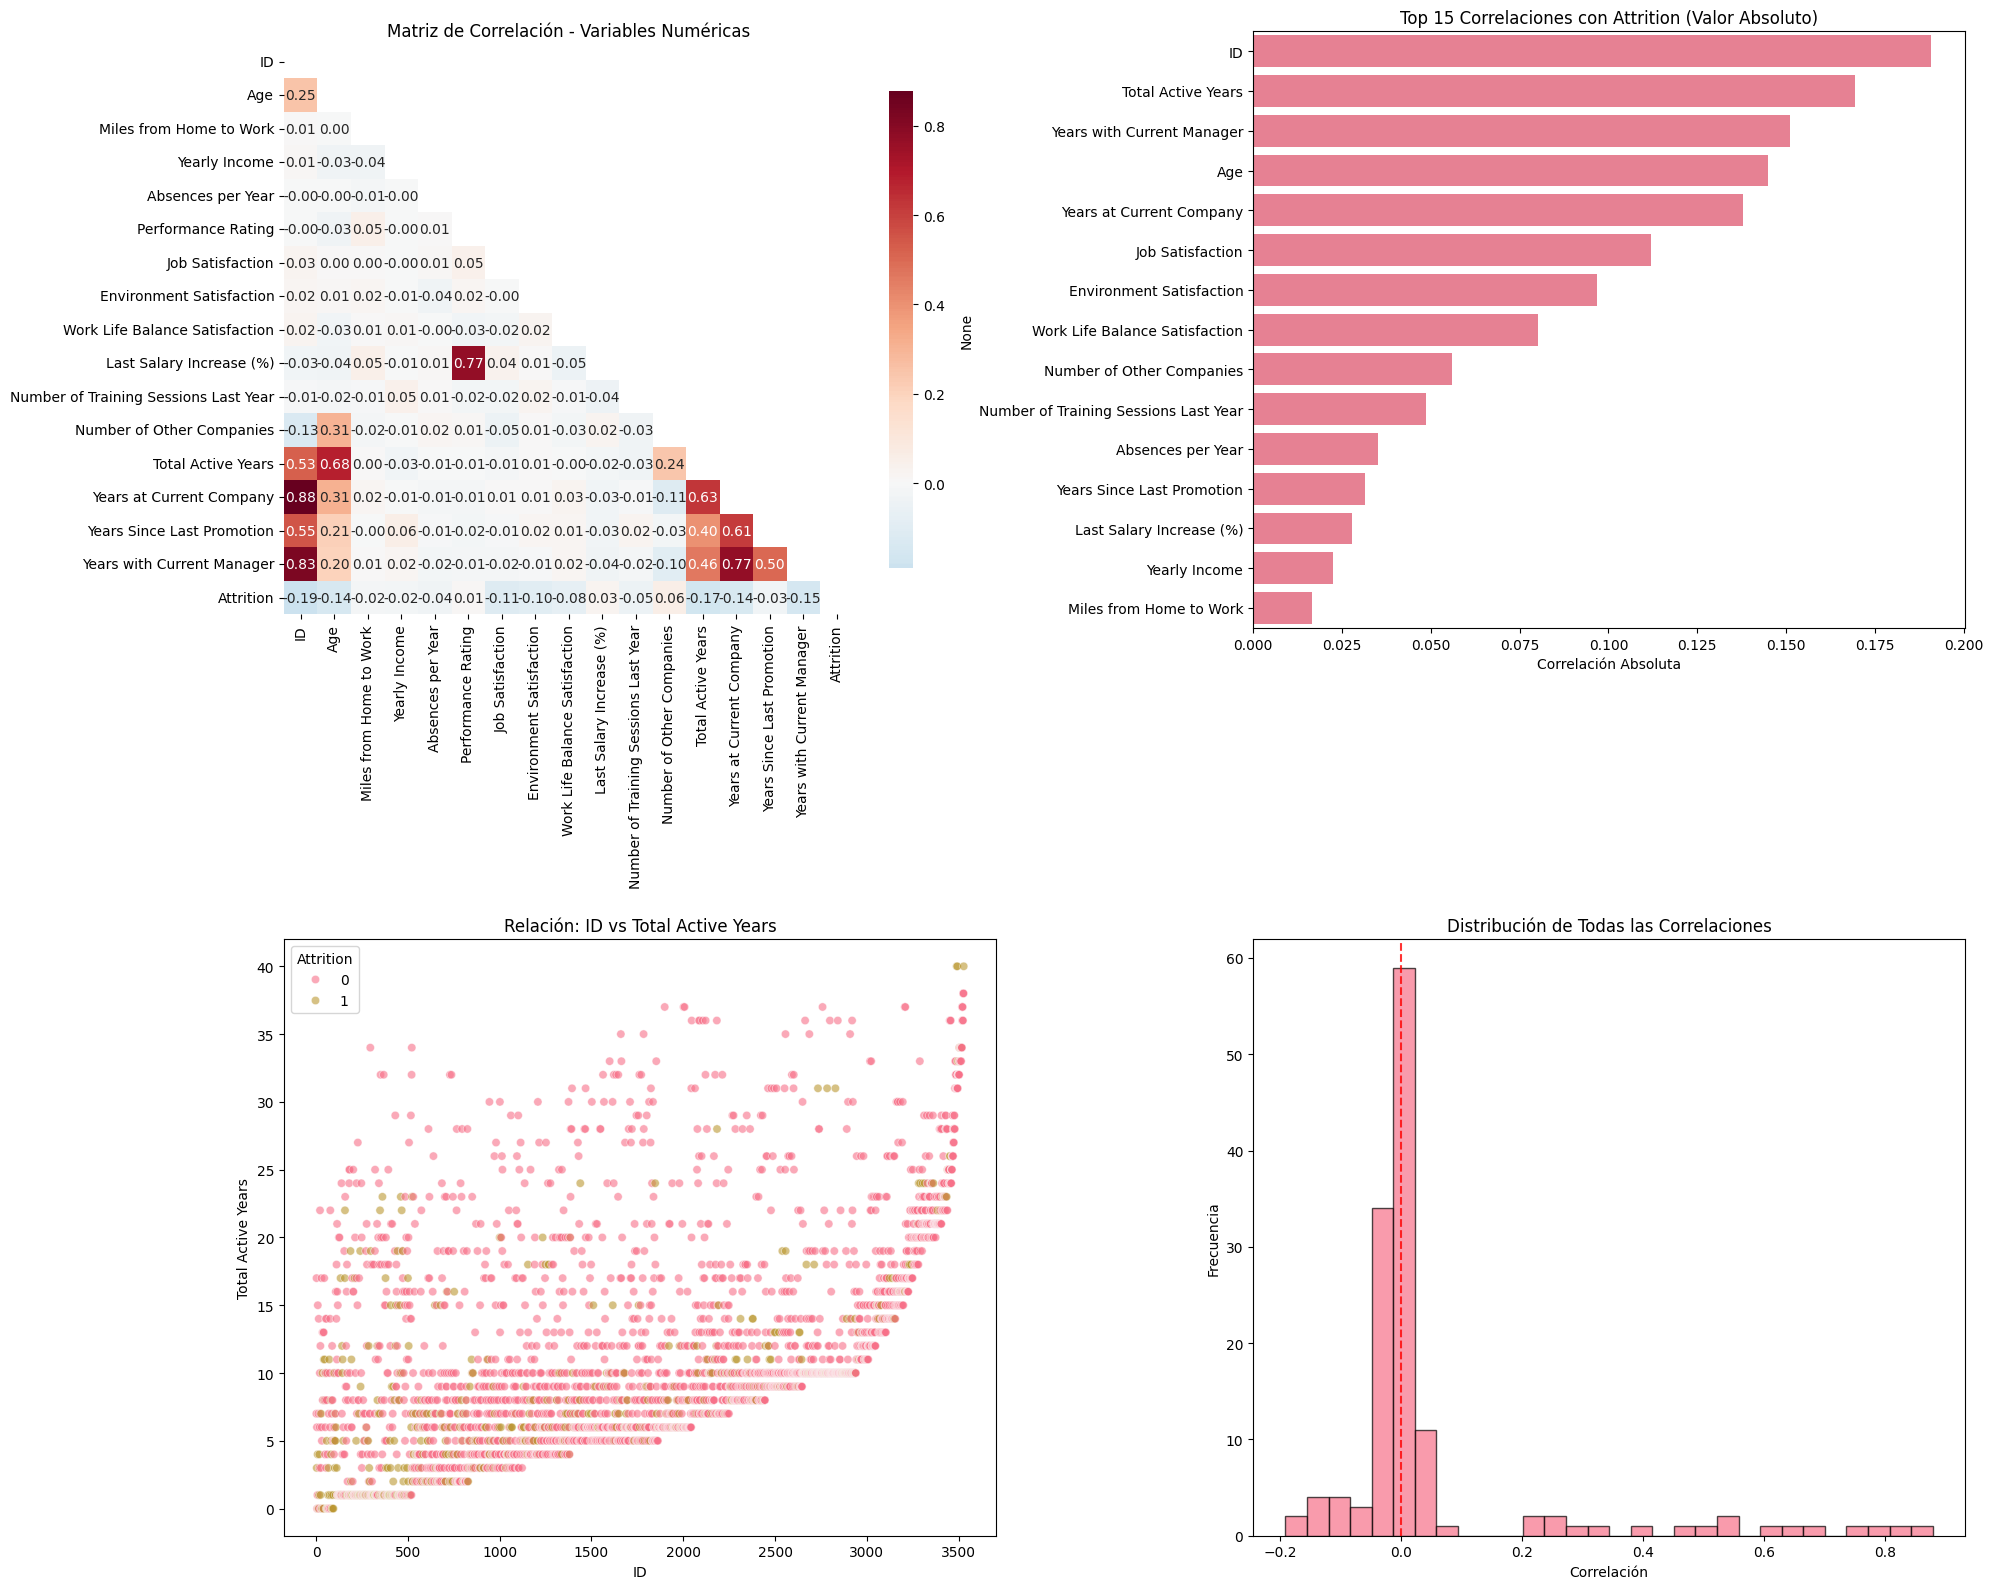

In [35]:

# 1. Análisis de correlaciones
print("📊 1. Análisis de correlaciones...")
target_corr = plot_correlation_analysis(data)


📈 2. Distribuciones de features...


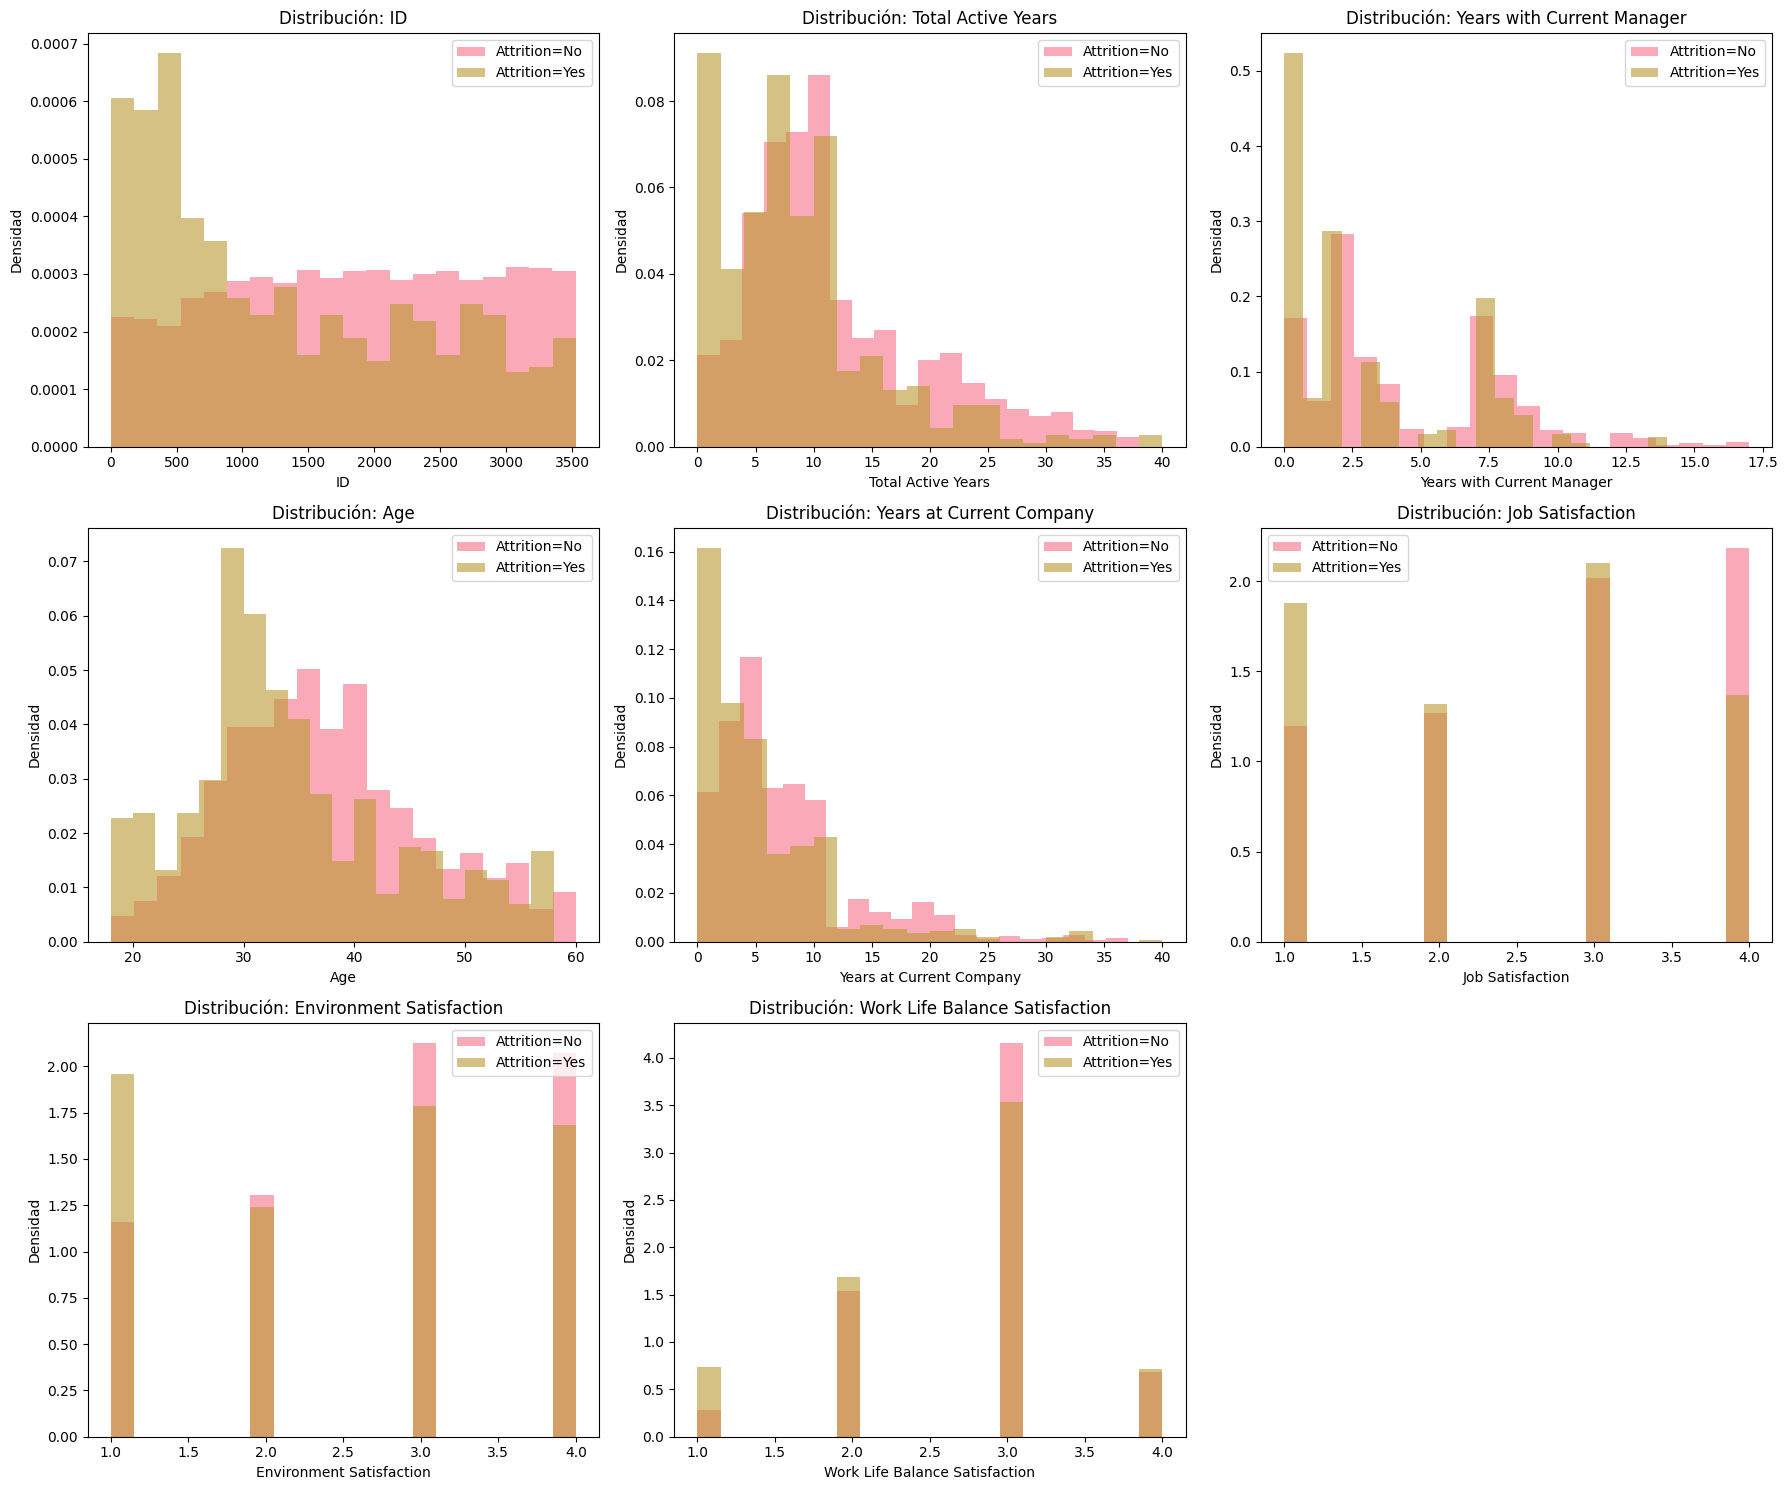

In [36]:
# 2. Distribuciones de features
print("📈 2. Distribuciones de features...")
plot_feature_distributions(data)



📋 3. Análisis categórico...


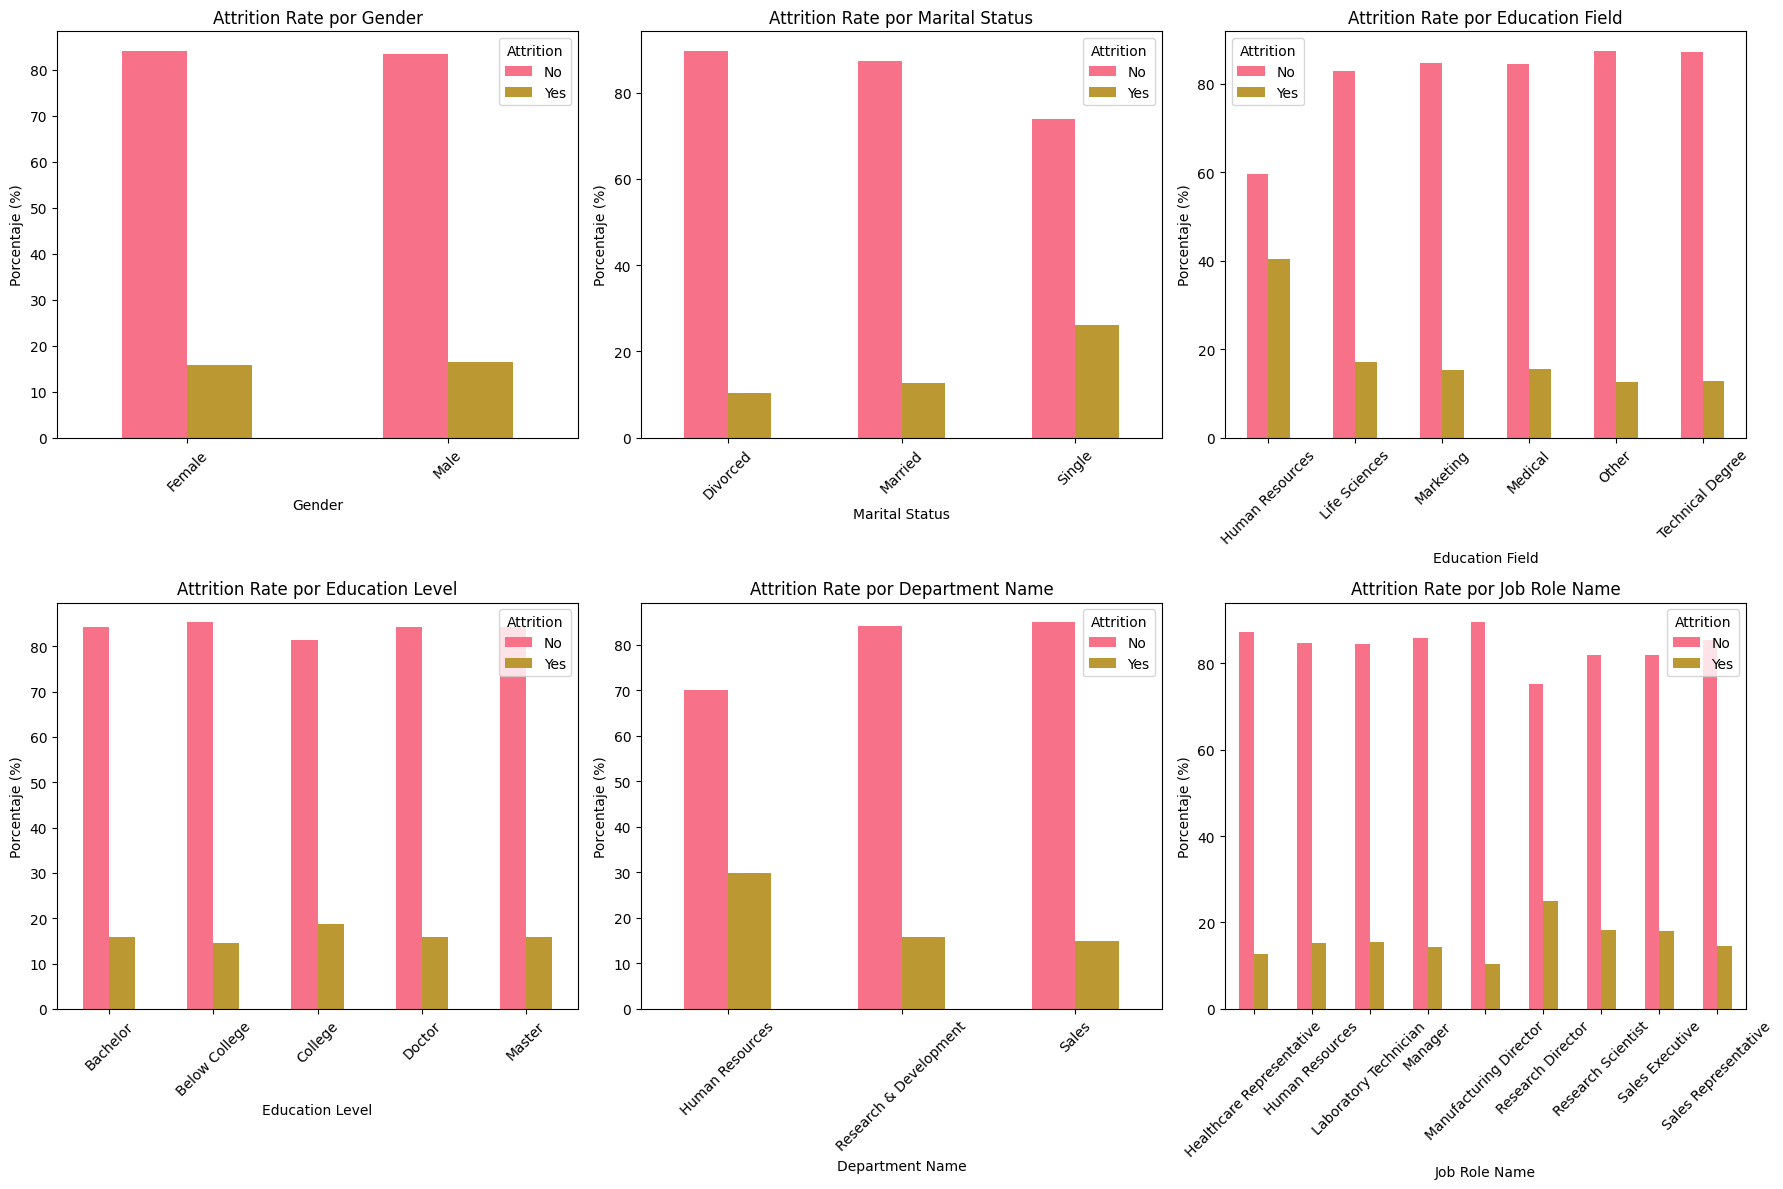

In [37]:
# 3. Análisis categórico
print("📋 3. Análisis categórico...")
plot_categorical_analysis(data)



🔍 4. Feature importance...


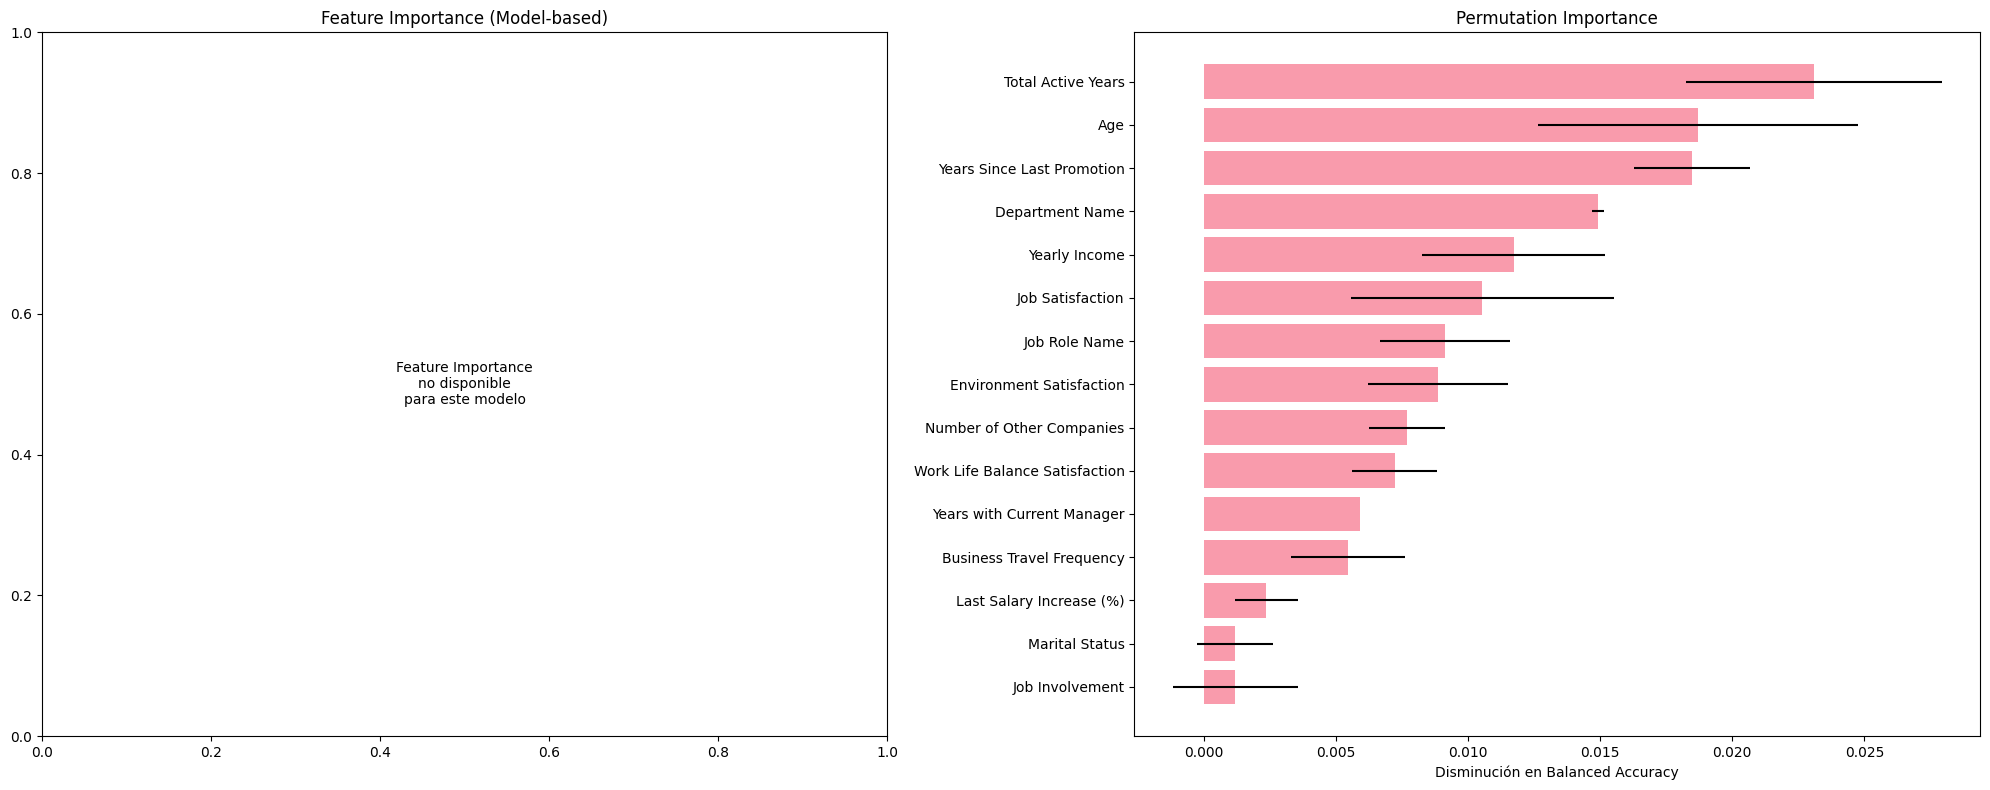

In [38]:
# 4. Feature importance (si se proporciona modelo)
if model is not None and X_train is not None and y_train is not None:
    print("🔍 4. Feature importance...")
    feature_names = X_train.columns.tolist() if hasattr(X_train, 'columns') else None
    plot_feature_importance(model, X_train, y_train, feature_names)



📊 5. Performance del modelo...


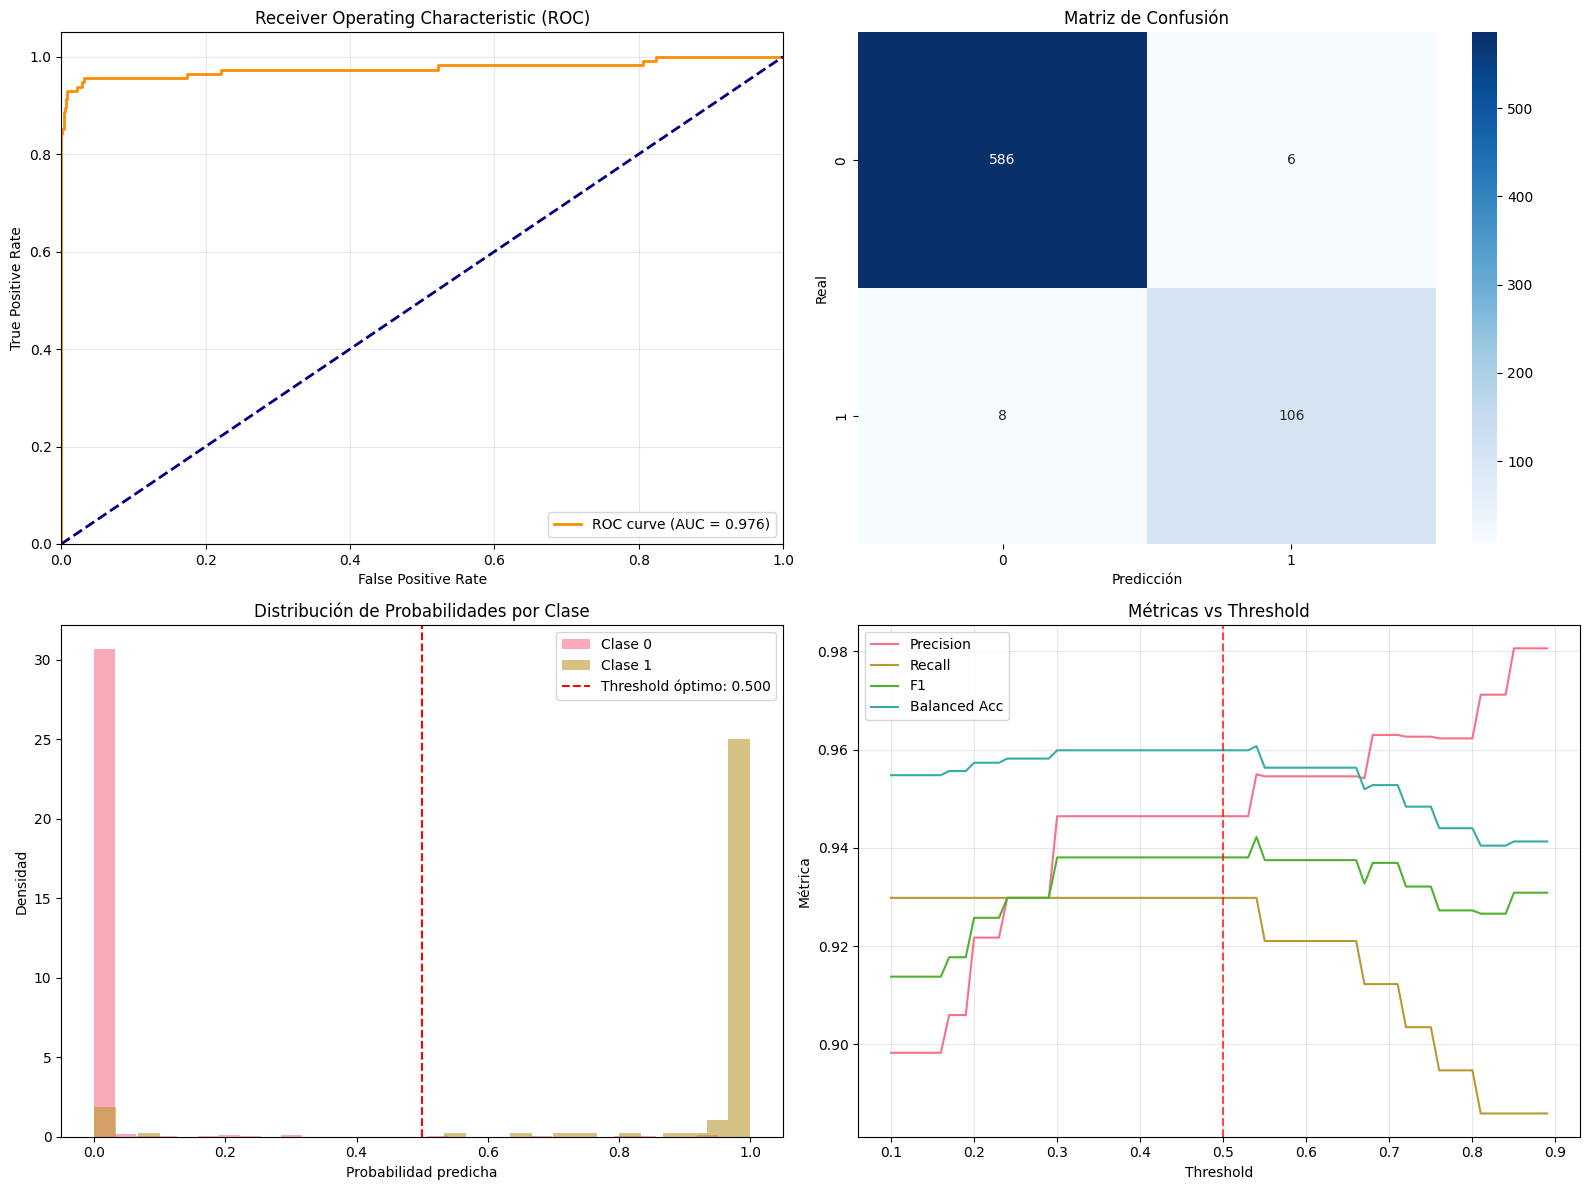

In [39]:
# 5. Performance del modelo (si se proporcionan predicciones)
if all(x is not None for x in [y_test, y_pred, y_proba]):
    print("📊 5. Performance del modelo...")
    plot_model_performance(y_test, y_pred, y_proba, optimal_threshold)

🏆 6. Comparación de modelos...


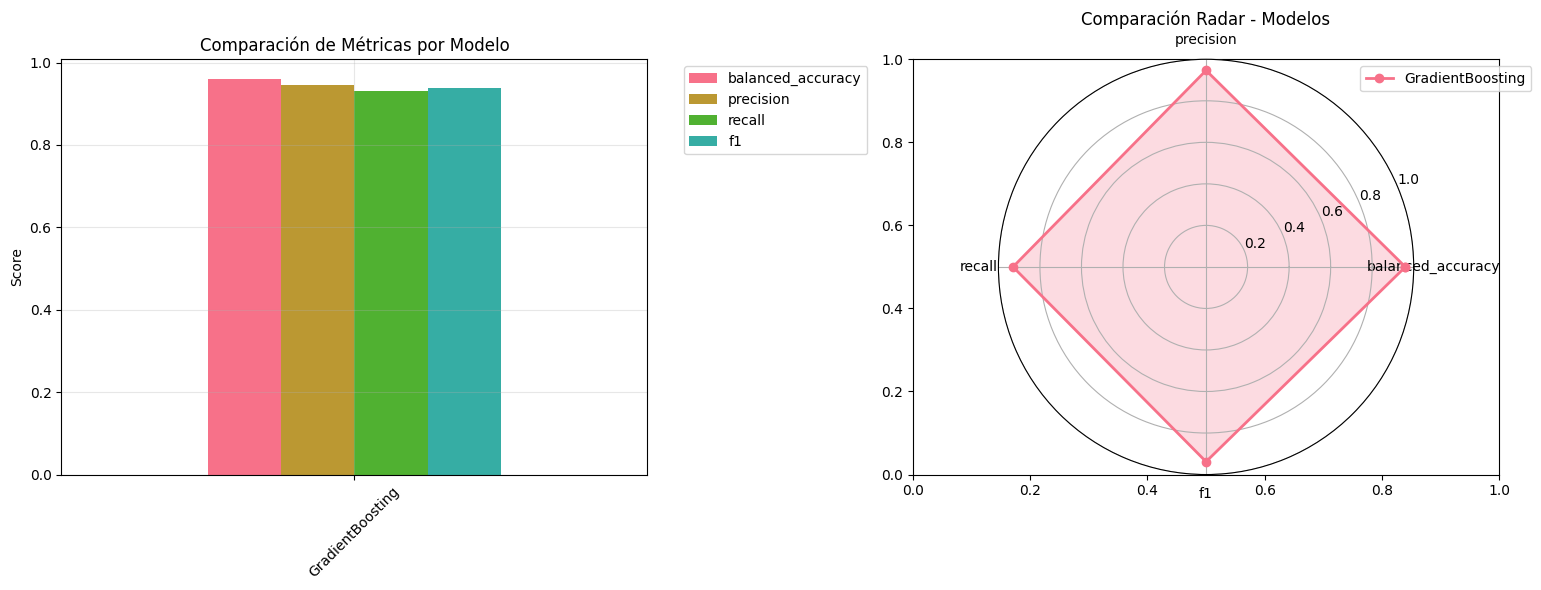

In [40]:
# 6. Comparación de modelos (si se proporciona)
if results_dict is not None:
    print("🏆 6. Comparación de modelos...")
    plot_model_comparison(results_dict)

## Parte Adicional del Proyecto: Intentos Fallidos

### Pruebas de Modelos

In [ ]:
grid= [
    # 1) Logistic Regression (l1/l2, con y sin class_weight, distintos solvers)
{
    'classifier': [LogisticRegression(random_state=42, max_iter=2000)],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear'],   # l1 soportado por liblinear/saga
    'classifier__C': [3],
    'classifier__class_weight': ['balanced'],
},
   ## 2) Árbol de decisión (más profundo, min_samples_* y max_features)
{
    'classifier': [DecisionTreeClassifier(random_state=42)],
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [10],
    'classifier__min_samples_split': [5],
    'classifier__min_samples_leaf': [2],
    'classifier__class_weight': ['balanced']
},
   ## 3) KNN (más vecinos, distancia y leaf_size)
{
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors': [9],
    'classifier__weights': ['uniform'],
    'classifier__p': [1],               
    'classifier__leaf_size': [15]
},
  # Random Forest optimizado para balanced accuracy
   ## 5) Random Forest (más n_estimators, max_features, bootstrap)
{
    'classifier': [RandomForestClassifier(random_state=42)],
    'classifier__n_estimators': [300],
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [10],
    'classifier__min_samples_split': [5],
    'classifier__min_samples_leaf': [2],
    'classifier__class_weight': ['balanced']
},
   ## 6) Gradient Boosting
{
    'classifier': [GradientBoostingClassifier(random_state=42)],
    'classifier__n_estimators': [600],
    'classifier__learning_rate': [0.1],
    'classifier__max_depth': [5],
    'classifier__min_samples_leaf': [2],
    'classifier__subsample': [0.9]
},
  ## 7) Extra Trees
{
    'classifier': [ExtraTreesClassifier(random_state=42)],
    'classifier__n_estimators': [200],
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [None],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [1],
    'classifier__class_weight': ['balanced']
},
  ## 8) AdaBoost
{
   'classifier': [AdaBoostClassifier(
       random_state=42,
       estimator=DecisionTreeClassifier(random_state=42)
   )],
   'classifier__algorithm': ['SAMME'],
   'classifier__n_estimators': [100],
   'classifier__learning_rate': [0.1],
   'classifier__estimator__max_depth': [1],
   'classifier__estimator__min_samples_leaf': [1]
},
  # multi-layer Perceptron
  {
      'classifier': [MLPClassifier(random_state=42, max_iter=1000)],
      'classifier__hidden_layer_sizes': [(50, 50)],
      'classifier__activation': ['relu'],
      'classifier__alpha': [0.01]
  }
]

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

search = GridSearchCV(
    estimator=ml_pipe_improved,
    param_grid=grid,
    scoring='balanced_accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    )
search.fit(X_train, y_train)
cv_results_df = pd.DataFrame(search.cv_results_)
score_cols = [
    col for col in cv_results_df.columns
    if col.startswith('split') and col.endswith('_test_score')
]
summary_cols = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score'] + score_cols
cv_results_summary = cv_results_df[summary_cols].copy()
cv_results_summary = cv_results_summary.sort_values('rank_test_score')

def _format_params(params: dict) -> str:
    return ', '.join(f"{key}={value}" for key, value in params.items())

cv_results_summary['params'] = cv_results_summary['params'].apply(_format_params)
cv_results_summary = cv_results_summary.rename(columns={
    'params': 'Parámetros',
    'mean_test_score': 'Balanced Accuracy media',
    'std_test_score': 'Desviación estándar',
    'rank_test_score': 'Ranking'
})

print("\nResultados completos de la búsqueda (ordenados por ranking):")
print(cv_results_summary.to_string(index=False))

#cv_results_summary.to_csv('cv_results_smote.csv', index=False)
#print("\n✓ Resultados de la búsqueda guardados en: cv_results_smote.csv")

if len(cv_results_summary) > 0:
    top_n = min(10, len(cv_results_summary))
    top_results = cv_results_summary.head(top_n)
    plt.figure(figsize=(12, max(6, top_n * 0.5)))
    sns.barplot(
        data=top_results,
        x='Balanced Accuracy media',
        y='Parámetros',
        palette='viridis'
    )
    plt.title(f'Mejores {top_n} combinaciones - Balanced Accuracy (CV)')
    plt.xlabel('Balanced Accuracy media (CV)')
    plt.ylabel('Parámetros')
    plt.tight_layout()
    #plt.savefig('cv_results_smote_top.png', dpi=150, bbox_inches='tight')
    #print("✓ Gráfico guardado en: cv_results_smote_top.png")
    plt.close()
else:
    print("No hay resultados disponibles para graficar.")

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Resultados completos de la búsqueda (ordenados por ranking):
                                                                                                                                                                                                                                                                                    Parámetros  Balanced Accuracy media  Desviación estándar  Ranking  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score
                                                                                       classifier=GradientBoostingClassifier(random_state=42), classifier__learning_rate=0.1, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__n_estimators=600, classifier__subsample=0.9                 0.902161             0.008032        1           0.888133           0.900060           0.912297           0.905745           0.904569
    

Los resultados son respecto a la media, por eso son más bajos que los obenidos arriba

## Parte Adicional del Proyecto: Posibles Mejoras